In [1]:
import pandas as pd
import numpy as np
from scipy.stats import truncnorm
from sklearn.metrics import r2_score, classification_report, roc_auc_score
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [107]:
bzr = pd.read_csv('er_lit/er_lit_matrix_alphabet_NNdb*_UpTo5chains.csv', sep=',')
bzr_y = pd.read_csv('er_lit/er_lit_y.csv', sep=',')

# for i, elem in bzr_y['IC50_uM'].items():
#     bzr_y['IC50_uM'][i] = float(elem.strip('[]').strip('()').split(', ')[0])
bzr_y = bzr_y - 1.0
bzr_np_y = bzr_y.to_numpy().reshape(-1)
bzr_y = pd.DataFrame([-1 if y_i <=0 else 1 for y_i in bzr_np_y])

In [108]:
def pred_with_distance(X, y, new, R=None, quantile=0.3, prob='classification', weighted=True):
    X = X.to_numpy()
    y = y.to_numpy()
    new = new.to_numpy()
    dist_vec = np.sqrt(np.sum((X - new)**2, axis=1))
    
    if R == None:
        R = np.quantile(dist_vec, quantile)
    mask = dist_vec <= R
    points_in_R = dist_vec[mask]
    
    if weighted:
        weights = []
        for i in range(len(points_in_R)):
            rv = truncnorm(0, R)
            weights.append(rv.pdf(points_in_R[i]))
        weights = np.array(weights)
    else:
        weights = np.ones(len(points_in_R))
    
    y_new = np.dot(y[mask].reshape(-1), weights)
        
    if prob == 'classification':
        return np.sign(y_new), R, mask.sum()
    else:
        return y_new

In [109]:
def go_and_show(bzr, bzr_y):
    fig, ax = plt.subplots(4, 2, figsize=(12, 25))
    fig.tight_layout()
    # not weighted
    
    
    ## fixed radius
    accur = []
    avg_dots = []
    Rs = np.linspace(2, 10.5, 20)

    for R in tqdm(Rs):
        preds = []
        dots_in = []
        for i in range(bzr.shape[0]):
            mask = np.arange(bzr.shape[0]) != i
            X = bzr.iloc[mask]
            new = bzr.iloc[i]
            y = bzr_y[mask]
            pred, _, dots = pred_with_distance(X, y, new, R=R, weighted=False)
            preds.append(pred)
            dots_in.append(dots)
        avg_dots.append(np.array(dots_in).mean())
        accur.append(accuracy_score(bzr_y.to_numpy().reshape(-1), preds))
        
    ax[0, 0].plot(Rs, accur)
    ax[0, 0].set_title('Accuracy. Fixed radius. Not weighted.')
    ax[0, 1].plot(Rs, avg_dots)
    ax[0, 1].set_title('Average number of dots in radius. Fixed radius. Not weighted')
    
    
    ## fixed quantile
    accur = []
    avg_Rs = []
    Qs = np.linspace(0.1, 0.7, 20)

    for q in tqdm(Qs):
        preds = []
        r_in = []
        for i in range(bzr.shape[0]):
            mask = np.arange(bzr.shape[0]) != i
            X = bzr.iloc[mask]
            new = bzr.iloc[i]
            y = bzr_y[mask]
            pred, r, _ = pred_with_distance(X, y, new, quantile=q, weighted=False)
            preds.append(pred)
            r_in.append(r)
        avg_Rs.append(np.array(r_in).mean())
        accur.append(accuracy_score(bzr_y.to_numpy().reshape(-1), preds))
    
    ax[1, 0].plot(Qs, accur)
    ax[1, 0].set_title('Accuracy. Fixed quantile. Not weighted')
    ax[1, 1].plot(Rs, avg_Rs)
    ax[1, 1].set_title('Average radius. Fixed quantile. Not weighted')
    
    
    # weighted
    
    ## fixed radius
    accur = []
    avg_dots = []
    Rs = np.linspace(2, 10.5, 20)

    for R in tqdm(Rs):
        preds = []
        dots_in = []
        for i in range(bzr.shape[0]):
            mask = np.arange(bzr.shape[0]) != i
            X = bzr.iloc[mask]
            new = bzr.iloc[i]
            y = bzr_y[mask]
            pred, _, dots = pred_with_distance(X, y, new, R=R, weighted=True)
            preds.append(pred)
            dots_in.append(dots)
        avg_dots.append(np.array(dots_in).mean())
        accur.append(accuracy_score(bzr_y.to_numpy().reshape(-1), preds))
        
    ax[2, 0].plot(Rs, accur)
    ax[2, 0].set_title('Accuracy. Fixed radius. Weighted.')
    ax[2, 1].plot(Rs, avg_dots)
    ax[2, 1].set_title('Average number of dots in radius. Fixed radius. Weighted')
    
    
    ## fixed quantile
    accur = []
    avg_Rs = []
    Qs = np.linspace(0.1, 0.7, 20)

    for q in tqdm(Qs):
        preds = []
        r_in = []
        for i in range(bzr.shape[0]):
            mask = np.arange(bzr.shape[0]) != i
            X = bzr.iloc[mask]
            new = bzr.iloc[i]
            y = bzr_y[mask]
            pred, r, _ = pred_with_distance(X, y, new, quantile=q, weighted=True)
            preds.append(pred)
            r_in.append(r)
        avg_Rs.append(np.array(r_in).mean())
        accur.append(accuracy_score(bzr_y.to_numpy().reshape(-1), preds))
    
    ax[3, 0].plot(Qs, accur)
    ax[3, 0].set_title('Accuracy. Fixed quantile. Weighted')
    ax[3, 1].plot(Rs, avg_Rs)
    ax[3, 1].set_title('Average radius. Fixed quantile. Weighted')
        
    fig.savefig('er_lit_alphabet_NNdb*_UpTo5chains.png', dpi=100)
    plt.show()
    
    return fig, ax

100%|██████████| 20/20 [23:25<00:00, 70.26s/it] 


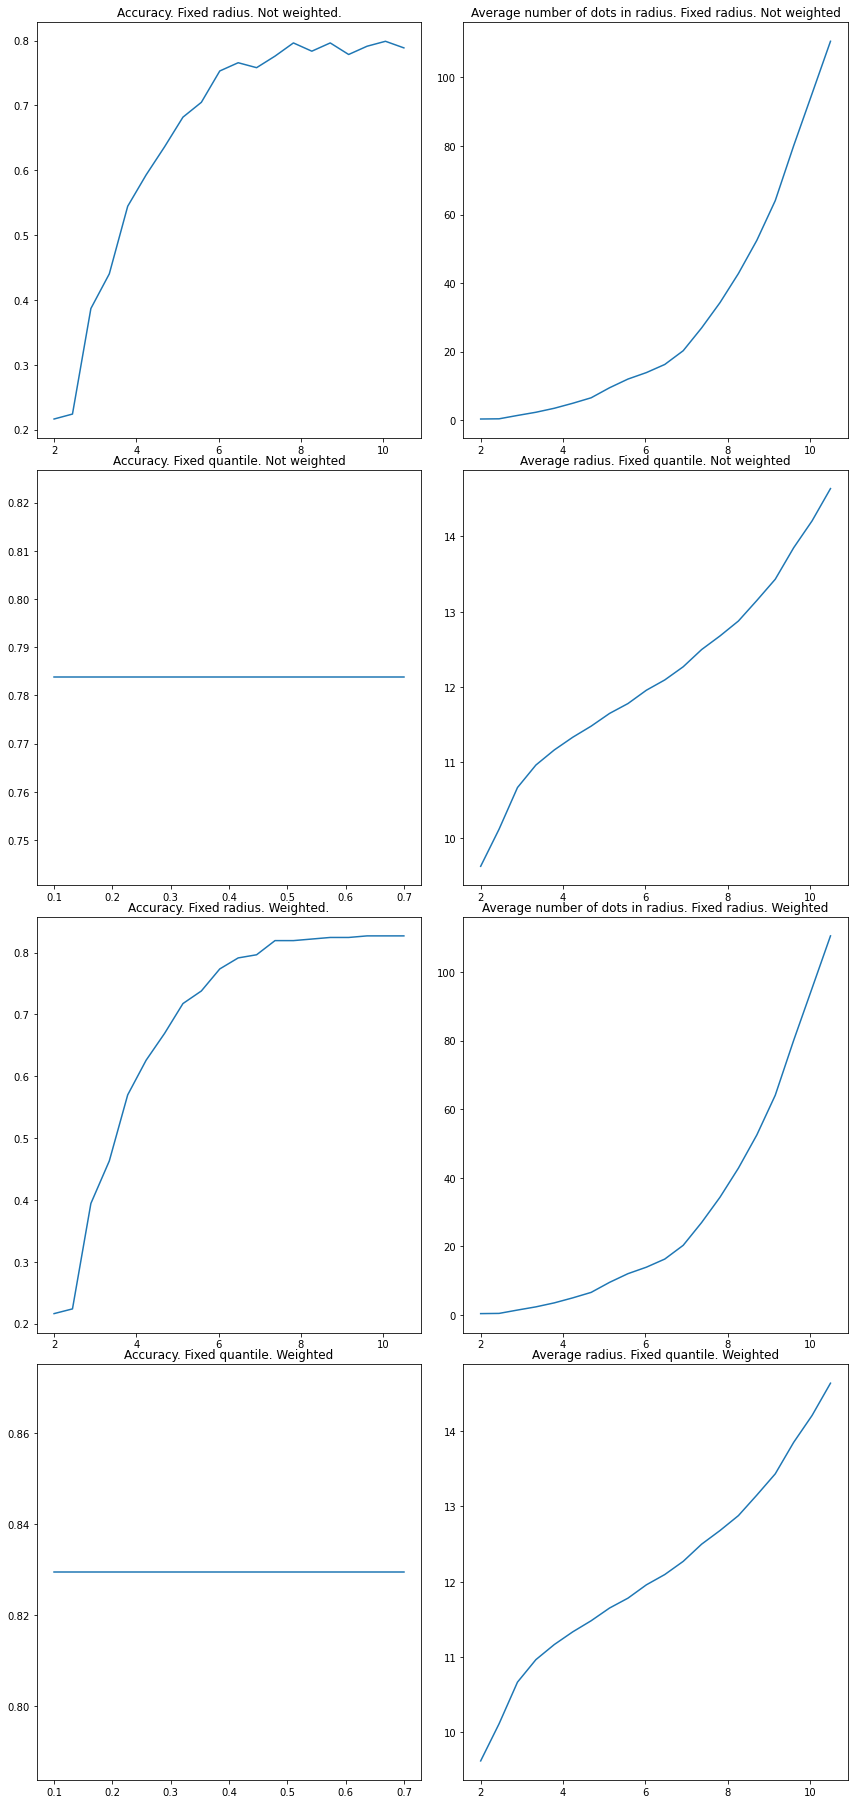

In [110]:
figu, axs = go_and_show(bzr, bzr_y)

In [3]:
def pred_with_distance(X, y, new, R=None, quantile=0.3, prob='classification'):
    X = X.to_numpy()
    y = y.to_numpy()
    new = new.to_numpy()
    dist_vec = np.sqrt(np.sum((X - new)**2, axis=1))
    
    if R == None:
        R = np.quantile(dist_vec, quantile)
    mask = dist_vec <= R
    points_in_R = dist_vec[mask]
    
    weights = []
    for i in range(len(points_in_R)):
        rv = truncnorm(0, R)
        weights.append(rv.pdf(points_in_R[i]))
    weights = np.array(weights)
    
    y_new = np.dot(y[mask].reshape(-1), weights)
        
    if prob == 'classification':
        return np.sign(y_new), R, mask.sum()
    else:
        return y_new
        

## Для фиксированных радиусов

In [12]:
accur = []
avg_dots = []
Rs = np.linspace(2, 10.5, 20)

for R in tqdm(Rs):
    preds = []
    dots_in = []
    for i in range(bzr.shape[0]):
        mask = np.arange(bzr.shape[0]) != i
        X = bzr.iloc[mask]
        new = bzr.iloc[i]
        y = bzr_y[mask]
        pred, _, dots = pred_with_distance(X, y, new, R=R)
        preds.append(pred)
        dots_in.append(dots)
    avg_dots.append(np.array(dots_in).mean())
    accur.append(accuracy_score(bzr_y.to_numpy().reshape(-1), preds))

100%|██████████████████████████████████████████████| 20/20 [14:58<00:00, 44.93s/it]


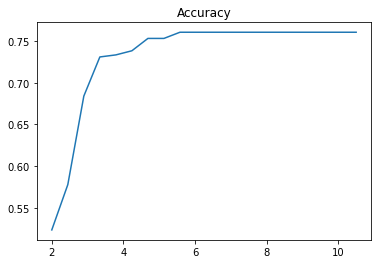

In [13]:
fig, ax = plt.subplots()
ax.plot(Rs, accur)
ax.set_title('Accuracy')
plt.show()

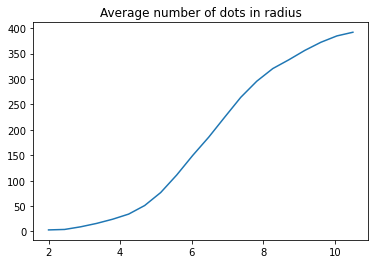

In [14]:
fig, ax = plt.subplots()
ax.plot(Rs, avg_dots)
ax.set_title('Average number of dots in radius')
plt.show()

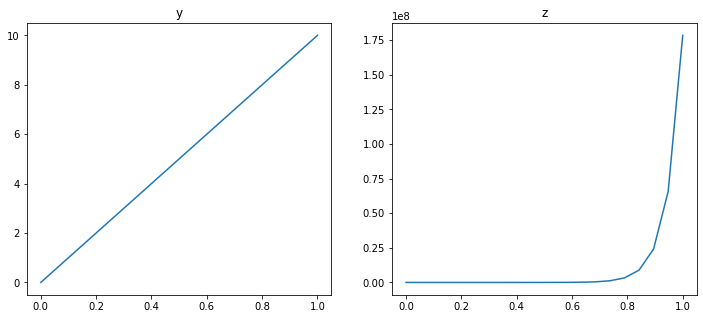

In [13]:
x = np.linspace(0, 1, 20)
y = np.linspace(0, 10, 20)
z = np.exp(np.arange(20))

fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(x, y)
ax[0].set_title('y')
ax[1].plot(x, z)
ax[1].set_title('z')
plt.show()

## Для фиксированной квантили точек внутри радиуса

In [15]:
accur = []
avg_Rs = []
Qs = np.linspace(0.1, 0.7, 20)

for q in tqdm(Qs):
    preds = []
    r_in = []
    for i in range(bzr.shape[0]):
        mask = np.arange(bzr.shape[0]) != i
        X = bzr.iloc[mask]
        new = bzr.iloc[i]
        y = bzr_y[mask]
        pred, r, _ = pred_with_distance(X, y, new, quantile=q)
        preds.append(pred)
        r_in.append(r)
    avg_Rs.append(np.array(r_in).mean())
    accur.append(accuracy_score(bzr_y.to_numpy().reshape(-1), preds))

100%|██████████████████████████████████████████████| 20/20 [12:59<00:00, 38.99s/it]


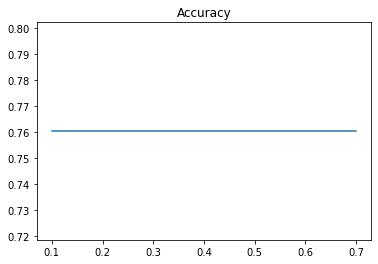

In [16]:
fig, ax = plt.subplots()
ax.plot(Qs, accur)
ax.set_title('Accuracy')
plt.show()

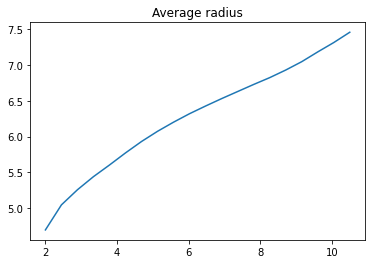

In [17]:
fig, ax = plt.subplots()
ax.plot(Rs, avg_Rs)
ax.set_title('Average radius')
plt.show()

- без взвешивания (просто кнн)
- другие матрицы посмотреть 
- произведение матрицы на себя
- гистограмма по accuracy на выборке
- посмотреть соответствие плохих точек здесь и отказов в DBSCAN
- посмотреть на матрице из 0 1 то же самое, но расстояние Хэмминга

In [ ]:
def pred_with_distance(X, y, new, R=None, quantile=0.3, prob='classification', weighted=True):
    X = X.to_numpy()
    y = y.to_numpy()
    new = new.to_numpy()
    dist_vec = np.sqrt(np.sum((X - new)**2, axis=1))
    
    if R == None:
        R = np.quantile(dist_vec, quantile)
    mask = dist_vec <= R
    points_in_R = dist_vec[mask]
    
    if weighted:
        weights = []
        for i in range(len(points_in_R)):
            rv = truncnorm(0, R)
            weights.append(rv.pdf(points_in_R[i]))
        weights = np.array(weights)
    else:
        weights = np.ones(len(points_in_R))
    
    y_new = np.dot(y[mask].reshape(-1), weights)
        
    if prob == 'classification':
        return np.sign(y_new), R, mask.sum()
    else:
        return y_new

## Без взвешивания, фиксированный радиус

In [ ]:
accur = []
avg_dots = []
Rs = np.linspace(2, 10.5, 20)

for R in tqdm(Rs):
    preds = []
    dots_in = []
    for i in range(bzr.shape[0]):
        mask = np.arange(bzr.shape[0]) != i
        X = bzr.iloc[mask]
        new = bzr.iloc[i]
        y = bzr_y[mask]
        pred, _, dots = pred_with_distance(X, y, new, R=R, weighted=False)
        preds.append(pred)
        dots_in.append(dots)
    avg_dots.append(np.array(dots_in).mean())
    accur.append(accuracy_score(bzr_y.to_numpy().reshape(-1), preds))

In [ ]:
fig, ax = plt.subplots()
ax.plot(Rs, accur)
ax.set_title('Accuracy')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(Rs, avg_dots)
ax.set_title('Average number of dots in radius')
plt.show()

## Без взвешивания, фиксированная квантиль точек

In [ ]:
accur = []
avg_Rs = []
Qs = np.linspace(0.1, 0.7, 20)

for q in tqdm(Qs):
    preds = []
    r_in = []
    for i in range(bzr.shape[0]):
        mask = np.arange(bzr.shape[0]) != i
        X = bzr.iloc[mask]
        new = bzr.iloc[i]
        y = bzr_y[mask]
        pred, r, _ = pred_with_distance(X, y, new, quantile=q, weighted=False)
        preds.append(pred)
        r_in.append(r)
    avg_Rs.append(np.array(r_in).mean())
    accur.append(accuracy_score(bzr_y.to_numpy().reshape(-1), preds))

In [ ]:
fig, ax = plt.subplots()
ax.plot(Qs, accur)
ax.set_title('Accuracy')
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.plot(Rs, avg_Rs)
ax.set_title('Average radius')
plt.show()

In [ ]:
def pred_with_distance(X, y, new, R=None, quantile=0.3, prob='classification', weighted=True):
    X = X.to_numpy()
    y = y.to_numpy()
    new = new.to_numpy()
    dist_vec = np.sqrt(np.sum((X - new)**2, axis=1))
    
    if R == None:
        R = np.quantile(dist_vec, quantile)
    mask = dist_vec <= R
    points_in_R = dist_vec[mask]
    
    if weighted:
        weights = []
        for i in range(len(points_in_R)):
            rv = truncnorm(0, R)
            weights.append(rv.pdf(points_in_R[i]))
        weights = np.array(weights)
    else:
        weights = np.ones(len(points_in_R))
    
    y_new = np.dot(y[mask].reshape(-1), weights)
        
    if prob == 'classification':
        return np.sign(y_new), R, mask.sum()
    else:
        return y_new